# DAD for Wave by Triplet Loss

## Settings

In [1]:
from pathlib import Path
import sys

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics

import torch
from torchvision import transforms

In [3]:
sys.path.append('../src')

import utils
from dataloader import ESC50DatasetTest
from models import EmbeddingNet, TripletNet

In [4]:
no_cuda = False
seed = 0

In [5]:
data_dir = Path().cwd().parent/'data'
raw_data_dir = data_dir/'external'/'ESC-50'
processed_data_dir = data_dir/'processed'/'ESC-50'
models_dir = Path().cwd().parent/'models'

In [6]:
#model_path = models_dir/'model_tmp.pth'
embeddingnet_path = models_dir/'embeddingnet_best_m08.pth'

In [7]:
metadata_path = raw_data_dir/'meta'/'esc50.csv'
audio_dir = raw_data_dir/'audio'
spectrogram_dir = processed_data_dir/'spectrogram'

In [8]:
train_metadata_path = processed_data_dir/'metadata_train.csv'
valid_metadata_path = processed_data_dir/'metadata_valid.csv'
test_metadata_path = processed_data_dir/'metadata_test.csv'

In [9]:
np.random.seed(seed)

In [10]:
use_cuda = torch.cuda.is_available() and (not no_cuda)
device = 'cuda' if use_cuda else 'cpu'
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = True

print('device: {}'.format(device))

device: cuda


In [11]:
def evaluate_bc(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    acc = metrics.accuracy_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)

    print('Acc: {:.4f}  Precision: {:.4f}  Recall: {:.4f}  F1: {:4f}'.format(acc, prec, recall, f1))
    print('Confusion Matrix')
    print(confusion_matrix)

In [12]:
def evaluate_auc(labels, scores):
    fpr, tpr, _ = metrics.roc_curve(labels, scores)
    auc = metrics.auc(fpr, tpr)

    plt.title('ROC curve (AUC = {:.2f})'.format(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

## Hyperparameters

In [13]:
input_size = (257, 431)
output_size = 128

batch_size = 8

## Dataloader

In [14]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

In [16]:
dataset = ESC50DatasetTest(
    test_metadata_path, audio_dir, spectrogram_dir, transform,
    )

In [17]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Model

In [18]:
embedding_net = EmbeddingNet(input_size, output_size).to(device)
embedding_net.eval()
embedding_net.load_state_dict(torch.load(str(embeddingnet_path)))

#model = TripletNet(embedding_net).to(device)
#model.eval()
#model.load_state_dict(torch.load(str(model_path)))

## Build Embeddings

In [19]:
embeddings_all = []
for i, (spec, label) in enumerate(dataloader):
    print('\rMinibatch {}/{}'.format(i+1, len(dataloader)), end='')
    if use_cuda: 
        spec =spec.cuda()
    embeddings = embedding_net(spec)
    embeddings = embeddings.cpu().detach().numpy().reshape(-1, output_size)
    embeddings_all.extend(list(embeddings))
print()
dataset.embeddings = np.array(embeddings_all)
dataset.embeddings.shape

Minibatch 25/25


(200, 128)

### Test Settings

In [20]:
label_normal = 1
label_abnormal = -1

In [21]:
dataset.metadata.loc[:, ['target', 'category']].drop_duplicates().reset_index(drop=True)

,target,category
0,2,pig
1,34,can_opening
2,24,coughing
3,40,helicopter
4,28,snoring


In [22]:
_label_normal = 24
indices_normal_all = dataset.label2indices[_label_normal]

In [23]:
n_ref = 15

In [61]:
# all
#indices_abnormal = np.array(list(set(dataset.metadata.index.values) - set(indices_normal_all)))

# one class
_label_abnormal = 40
#indices_abnormal = np.array(list(dataset.label2indices[_label_abnormal]))

# a part of one class
n_abnormal = 25
indices_abnormal = np.random.permutation(dataset.label2indices[_label_abnormal])[:n_abnormal]

indices_abnormal

array([126, 144, 139, 155, 128, 157, 131, 121, 148, 127, 151, 130, 147,
       152, 150, 153, 122, 159, 138, 146, 142, 145, 120, 158, 129])

## Preparation

In [62]:
_indices_ref = np.random.permutation(range(len(indices_normal_all)))[:n_ref]
indices_ref = np.array(indices_normal_all)[_indices_ref]

In [63]:
embeddings_ref = dataset.embeddings[indices_ref]
embeddings_ref.shape

(15, 128)

In [64]:
indices_normal = np.array(sorted(list(set(indices_normal_all) - set(indices_ref))))
embeddings_normal = dataset.embeddings[indices_normal]
embeddings_normal.shape

(25, 128)

In [65]:
embeddings_abnormal = dataset.embeddings[indices_abnormal]
embeddings_abnormal.shape

(25, 128)

In [66]:
labels = [label_normal]*len(embeddings_normal) + [label_abnormal]*len(embeddings_abnormal)
print(labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


## Threshold

### Euclid Distance

In [67]:
threshold = 0.3

In [68]:
data_list = []
for embedding in embeddings_normal:
    euclid_distances = np.sqrt(np.sum((embedding[np.newaxis, :] - embeddings_ref)**2, axis=1))
    data = pd.DataFrame(euclid_distances).describe()
    data_list.append(data.to_dict()[0])
euclid_distance_statistics_normal = pd.io.json.json_normalize(data_list)

In [69]:
print('mean: {:.4f}  max: {:.4f}  min: {:.4f}'.format(
    euclid_distance_statistics_normal['mean'].mean(),
    euclid_distance_statistics_normal['max'].max(),
    euclid_distance_statistics_normal['min'].min(),
    ))

mean: 0.2914  max: 0.8473  min: 0.0286


In [70]:
euclid_distance_statistics_normal

,25%,50%,75%,count,max,mean,min,std
0,0.068327,0.143908,0.410029,15.0,0.781108,0.262876,0.038522,0.242809
1,0.120896,0.249572,0.461884,15.0,0.831046,0.314955,0.029517,0.238012
2,0.122367,0.153582,0.312554,15.0,0.689098,0.240430,0.068554,0.184538
3,0.250621,0.422561,0.458773,15.0,0.499652,0.356339,0.091819,0.133963
4,0.236262,0.260566,0.311425,15.0,0.591487,0.282285,0.051798,0.112533
5,0.375363,0.416005,0.444036,15.0,0.502245,0.392905,0.166264,0.087596
6,0.276472,0.398789,0.451110,15.0,0.523466,0.359468,0.166657,0.124299
7,0.207073,0.350723,0.397086,15.0,0.446109,0.305920,0.089066,0.115183
8,0.094463,0.159458,0.350736,15.0,0.721373,0.247964,0.049475,0.211194
9,0.220958,0.254802,0.316583,15.0,0.532809,0.269543,0.128348,0.103010


In [71]:
data_list = []
for embedding in embeddings_abnormal:
    euclid_distances = np.sqrt(np.sum((embedding[np.newaxis, :] - embeddings_ref)**2, axis=1))
    data = pd.DataFrame(euclid_distances).describe()
    data_list.append(data.to_dict()[0])
euclid_distance_statistics_abnormal = pd.io.json.json_normalize(data_list)

In [72]:
print('mean: {:.4f}  max: {:.4f}  min: {:.4f}'.format(
    euclid_distance_statistics_abnormal['mean'].mean(),
    euclid_distance_statistics_abnormal['max'].max(),
    euclid_distance_statistics_abnormal['min'].min(),
    ))

mean: 1.0713  max: 1.3723  min: 0.0831


In [73]:
euclid_distance_statistics_abnormal

,25%,50%,75%,count,max,mean,min,std
0,0.845610,0.863298,0.896818,15.0,0.985924,0.874654,0.793268,0.048335
1,1.229625,1.251447,1.265519,15.0,1.282636,1.235365,1.070937,0.054560
2,0.112906,0.165897,0.427383,15.0,0.781984,0.294168,0.083076,0.231020
3,1.243132,1.267791,1.278886,15.0,1.296733,1.248842,1.083506,0.055207
4,1.156926,1.181194,1.195335,15.0,1.218681,1.167730,1.051884,0.044390
5,1.123991,1.167595,1.188967,15.0,1.219629,1.138453,0.907243,0.079502
6,1.335870,1.353830,1.357742,15.0,1.368545,1.335031,1.193854,0.045507
7,1.340444,1.357571,1.361820,15.0,1.372257,1.339464,1.201065,0.044508
8,0.352895,0.383481,0.559615,15.0,0.786145,0.466140,0.316288,0.163467
9,0.944075,0.967580,0.997705,15.0,1.062393,0.969698,0.888167,0.044792


#### Score and Predict

In [74]:
column_name = 'mean'
scores = (
    list(euclid_distance_statistics_normal[column_name].values)
    + list(euclid_distance_statistics_abnormal[column_name].values)
    )

In [75]:
preds = [
    label_normal
    if (score < threshold)
    else label_abnormal
    for score in scores
    ]

In [76]:
scores = [-score for score in scores]

#### Evaluate

In [77]:
print('#Pred Normal: {}'.format(preds.count(1)))

#Pred Normal: 16


In [78]:
evaluate_bc(labels, preds)

Acc: 0.7800  Precision: 0.9375  Recall: 0.6000  F1: 0.731707
Confusion Matrix
[[24  1]
 [10 15]]


AUC: 0.9808


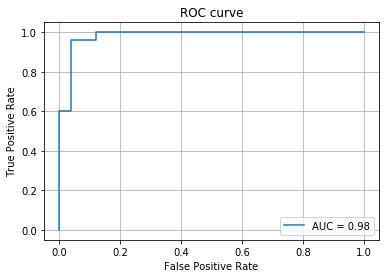

In [79]:
# AUROC

fpr, tpr, _ = metrics.roc_curve(labels, scores)
auc = metrics.auc(fpr, tpr)
print('AUC: {:.4f}'.format(auc))

plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

### Cosine Similarity

#### Watch Data

In [80]:
threshold = 0.75

In [81]:
data_list = []
for embedding in embeddings_normal:
    cosine_similarities = embeddings_ref.dot(embedding)
    data = pd.DataFrame(cosine_similarities).describe()
    data_list.append(data.to_dict()[0])
cosine_similarity_statistics_normal = pd.io.json.json_normalize(data_list)

In [82]:
print('mean: {:.4f}  max: {:.4f}  min: {:.4f}'.format(
    cosine_similarity_statistics_normal['mean'].mean(),
    cosine_similarity_statistics_normal['max'].max(),
    cosine_similarity_statistics_normal['min'].min(),
    ))

mean: 0.9435  max: 0.9996  min: 0.6411


In [83]:
cosine_similarity_statistics_normal

,25%,50%,75%,count,max,mean,min,std
0,0.914792,0.989645,0.997663,15.0,0.999258,0.937935,0.694935,0.091923
1,0.893094,0.968857,0.992692,15.0,0.999564,0.923965,0.654682,0.099842
2,0.950372,0.988206,0.992287,15.0,0.997650,0.955205,0.762572,0.067025
3,0.894709,0.910721,0.967239,15.0,0.995785,0.928137,0.875174,0.041723
4,0.951482,0.966053,0.972011,15.0,0.998659,0.954248,0.825072,0.039198
5,0.901274,0.913470,0.929516,15.0,0.986178,0.919232,0.873875,0.030365
6,0.898203,0.920484,0.961761,15.0,0.986113,0.928181,0.862992,0.042416
7,0.920916,0.938497,0.978309,15.0,0.996034,0.947015,0.900493,0.032472
8,0.936718,0.987287,0.995536,15.0,0.998776,0.948442,0.739811,0.077375
9,0.949888,0.967538,0.975339,15.0,0.991763,0.958721,0.858057,0.033092


In [84]:
data_list = []
for embedding in embeddings_abnormal:
    cosine_similarities = embeddings_ref.dot(embedding)
    data = pd.DataFrame(cosine_similarities).describe()
    data_list.append(data.to_dict()[0])
cosine_similarity_statistics_abnormal = pd.io.json.json_normalize(data_list)

In [85]:
print('mean: {:.4f}  max: {:.4f}  min: {:.4f}'.format(
    cosine_similarity_statistics_abnormal['mean'].mean(),
    cosine_similarity_statistics_abnormal['max'].max(),
    cosine_similarity_statistics_abnormal['min'].min(),
    ))

mean: 0.3617  max: 0.9965  min: 0.0585


In [86]:
cosine_similarity_statistics_abnormal

,25%,50%,75%,count,max,mean,min,std
0,0.597778,0.627358,0.642469,15.0,0.685363,0.616400,0.513977,0.043098
1,0.199227,0.216940,0.244003,15.0,0.426547,0.235547,0.177423,0.064382
2,0.907305,0.986239,0.993581,15.0,0.996549,0.931826,0.694250,0.093219
3,0.182221,0.196353,0.227291,15.0,0.413007,0.218775,0.159242,0.065907
4,0.285581,0.302390,0.330752,15.0,0.446770,0.317284,0.257408,0.050470
5,0.293177,0.318361,0.368322,15.0,0.588455,0.349013,0.256252,0.085156
6,0.078268,0.083572,0.107718,15.0,0.287356,0.107879,0.063542,0.058471
7,0.072723,0.078500,0.101599,15.0,0.278721,0.101993,0.058455,0.057418
8,0.842013,0.926471,0.937732,15.0,0.949981,0.878887,0.690988,0.089212
9,0.502244,0.531895,0.554360,15.0,0.605580,0.528907,0.435661,0.043676


#### Predict and Score

In [87]:
column_name = 'mean'
scores = (
    list(cosine_similarity_statistics_normal[column_name].values)
    + list(cosine_similarity_statistics_abnormal[column_name].values)
    )

In [88]:
preds = [
    label_normal
    if (score > threshold)
    else label_abnormal
    for score in scores
    ]

#### Evaluate

In [89]:
print('#Pred Normal: {}'.format(preds.count(1)))

#Pred Normal: 30


In [90]:
evaluate_bc(labels, preds)

Acc: 0.9000  Precision: 0.8333  Recall: 1.0000  F1: 0.909091
Confusion Matrix
[[20  5]
 [ 0 25]]


AUC: 0.9904


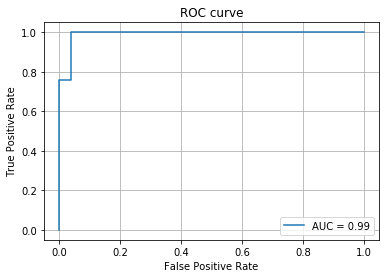

In [91]:
# AUROC

fpr, tpr, _ = metrics.roc_curve(labels, scores)
auc = metrics.auc(fpr, tpr)
print('AUC: {:.4f}'.format(auc))

plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

## Test by LOF

#### Train

In [92]:
clf = LocalOutlierFactor(
    n_neighbors=1,
    novelty=True,
    contamination='auto',
    )

In [93]:
clf.fit(embeddings_ref)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=None,
          n_neighbors=1, novelty=True, p=2)

#### Score and Predict

In [94]:
embeddings = list(embeddings_normal) + list(embeddings_abnormal)
preds = clf.predict(embeddings)
scores = clf.score_samples(embeddings)

In [95]:
print('#Pred Normal: {}'.format(list(preds).count(1)))

#Pred Normal: 23


#### Evaluate

In [96]:
evaluate_bc(labels, preds)

Acc: 0.9600  Precision: 1.0000  Recall: 0.9200  F1: 0.958333
Confusion Matrix
[[25  0]
 [ 2 23]]


AUC: 0.9936


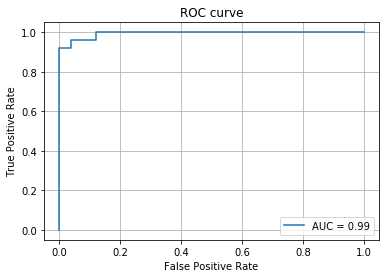

In [97]:
# AUROC

fpr, tpr, _ = metrics.roc_curve(labels, scores)
auc = metrics.auc(fpr, tpr)
print('AUC: {:.4f}'.format(auc))

plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()